# Pathological Voices Detection

In [105]:
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.svm import SVC

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

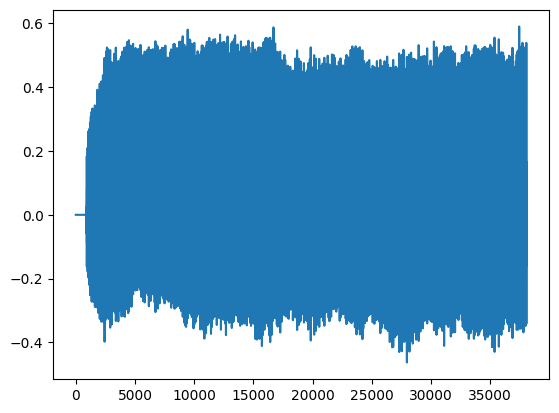

In [64]:
df1 = pd.read_csv("C:/Users/aless/Desktop/project/VOICED DATASET/voice001.txt",  delimiter='\t')
plt.plot(df1)
plt.show()

In [65]:
array = df1.values
array = np.transpose(array)

In [66]:
gasf = GramianAngularField(method='summation', image_size=250)
img1 = gasf.transform(array)
gadf = GramianAngularField(method='difference', image_size=250)
img2 = gadf.transform(array)
img = np.concatenate((img1,img2,np.zeros((1,250,250))),axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


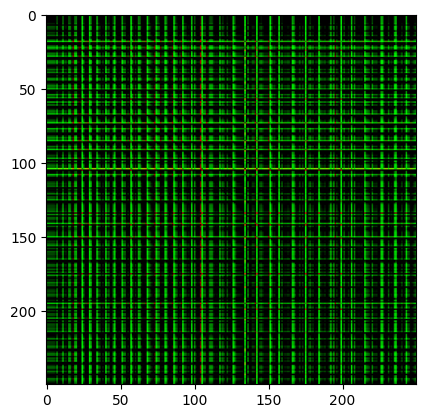

In [67]:
plt.imshow(img.transpose(1,2,0))
plt.show()

In [11]:
source_folder = "C:/Users/aless/Desktop/project/VOICED DATASET"
target_folder = "C:/Users/aless/Desktop/project/imgs"

# Create the target folder if it doesn't exist
os.makedirs(target_folder, exist_ok=True)

# List all files in the source folder
file_list = os.listdir(source_folder)

In [68]:
for filename in tqdm(file_list, desc="Processing files"):
    if filename.endswith('.txt'):
        # Read the data from the file
        file_path = os.path.join(source_folder, filename)
        data = pd.read_csv(file_path,  delimiter='\t')

        array = data.values
        array = np.transpose(array)
        
        gasf = GramianAngularField(method='summation', image_size=250)
        img1 = gasf.transform(array)
        
        gadf = GramianAngularField(method='difference', image_size=250)
        img2 = gadf.transform(array)
        
        # Concatenate the transformed images
        img = np.concatenate((img1, img2, np.zeros((1, 250, 250))), axis=0)
        
        # Save the produced image in the target folder as jpg
        target_path = os.path.join(target_folder, filename.replace('.txt', '.jpg'))

        # Convert numpy array to PIL Image and save as jpg
        img = (img * 255).astype(np.uint8)
        img = np.transpose(img, (1,2,0))
        pil_img = Image.fromarray(img)
        pil_img.save(target_path)

Processing files: 100%|██████████| 208/208 [00:06<00:00, 32.08it/s]


## Preprocessing

In [2]:
print('Folders inside the main directory: ', os.listdir("C:\\Users\\aless\\Desktop\\project\\imgs"))

Folders inside the main directory:  ['healthy', 'pathological']


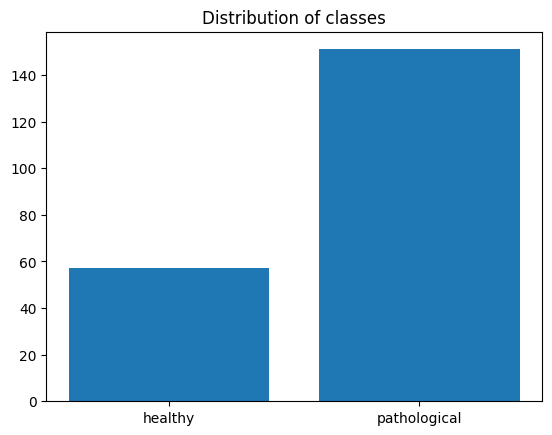

In [3]:
classes = os.listdir("C:\\Users\\aless\\Desktop\\project\\imgs")
sum_images = []
for i in classes:
    img_base_path = "C:\\Users\\aless\\Desktop\\project\\imgs/" + str(i)
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes')
plt.show()

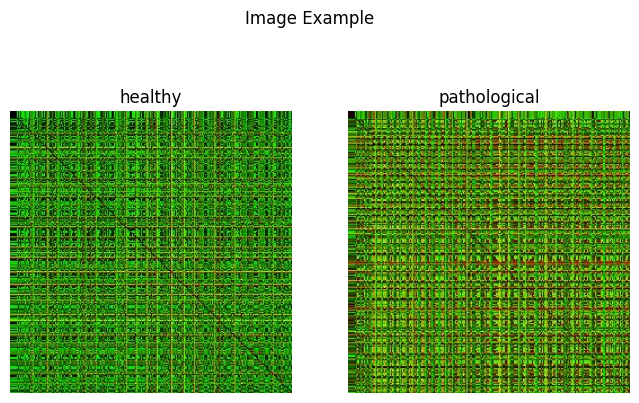

In [5]:
images = []
paths = []

fig,ax = plt.subplots(1,2,figsize = (8,5))
ax = ax.ravel()

for idx, i in enumerate(classes):
    img_base_path = "C:\\Users\\aless\\Desktop\\project\\imgs/" + str(i) #link of the subfolders
    timages = os.listdir(img_base_path) #list of images inside each subfolders
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[idx]
    ax[idx].axis('off')
    ax[idx].imshow(image,cmap = 'gray')
    ax[idx].set_title(str(i))

plt.suptitle('Image Example')
plt.show()

## OpenCV

In [115]:
SZ = 20
bin_n = 32 # Number of bins
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

In [116]:
def deskew(img):
   img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   m = cv2.moments(img)
   if abs(m['mu02']) < 1e-2:
     return img.copy()
   skew = m['mu11']/m['mu02']
   M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
   img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
   return img

In [117]:
img = cv2.imread("C:\\Users\\aless\\Desktop\\project\\imgs\\pathological\\voice001.jpg")
deskewed = deskew(img)

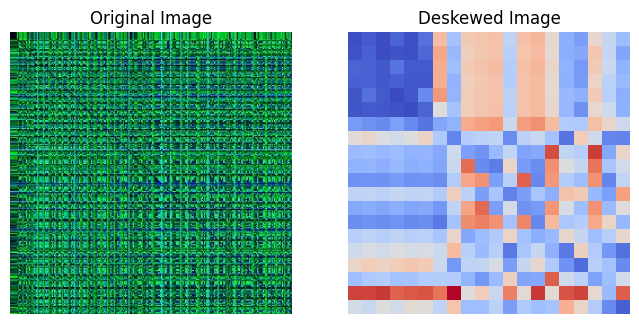

In [118]:
fig,ax = plt.subplots(1,2,figsize = (8,5))
ax = ax.ravel()
ax[0].axis('off')
ax[0].imshow(img,cmap = 'coolwarm')
ax[0].set_title('Original Image')
ax[1].axis('off')
ax[1].imshow(deskewed, cmap='coolwarm')
ax[1].set_title('Deskewed Image')

plt.show()

In [119]:
def hog(img):
   gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
   gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
   mag, ang = cv2.cartToPolar(gx, gy)
   bins = np.int32(bin_n*ang/(2*np.pi))
   bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
   mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
   hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
   hist = np.hstack(hists) # hist is a 64 bit vector
   return hist

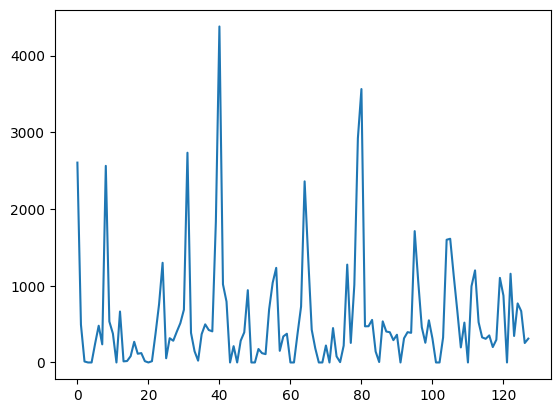

In [120]:
hogged = hog(deskewed)
plt.plot(hogged)
plt.show()

In [121]:
# Initialize variables
img_folder_1 = 'C:\\Users\\aless\\Desktop\\project\\imgs\\healthy'
img_folder_2 = 'C:\\Users\\aless\\Desktop\\project\\imgs\\pathological'
imgs = []
labels = []

# Process images in folder 1
for img_name in os.listdir(img_folder_1):
    img_path = os.path.join(img_folder_1, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = deskew(img)
        img = hog(img)
        imgs.append(img)
        labels.append(0)

# Process images in folder 2
for img_name in os.listdir(img_folder_2):
    img_path = os.path.join(img_folder_2, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = deskew(img)
        img = hog(img)
        imgs.append(img)
        labels.append(1)

# Convert the lists to NumPy arrays
imgs = np.array(imgs)
labels = np.array(labels)

# Print the shape of the arrays to verify
print("Images shape:", imgs.shape)
print("Labels shape:", labels.shape)

Images shape: (208, 128)
Labels shape: (208,)


In [211]:
df = pd.DataFrame(imgs, labels)

## Training

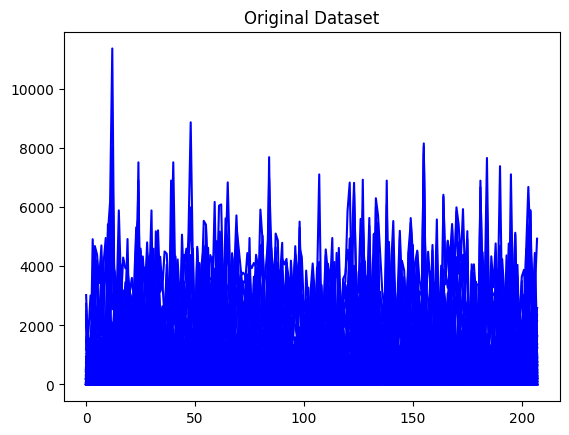

In [218]:
plt.plot(imgs, color='blue')
plt.title('Original Dataset')
plt.show()

In [199]:
scaler = StandardScaler()
x = scaler.fit_transform(imgs)

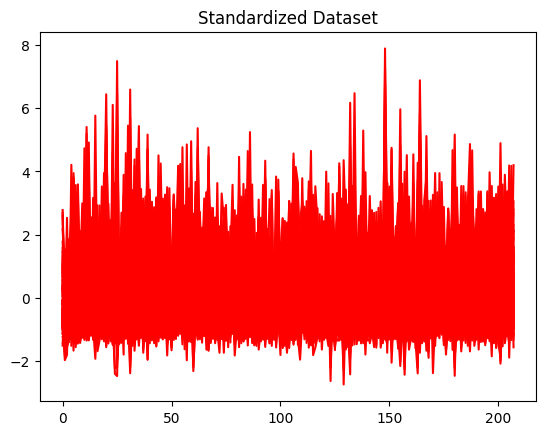

In [219]:
plt.plot(x, color='red')
plt.title('Standardized Dataset')
plt.show()

In [200]:
sm = SMOTE(random_state=42, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(x, labels)

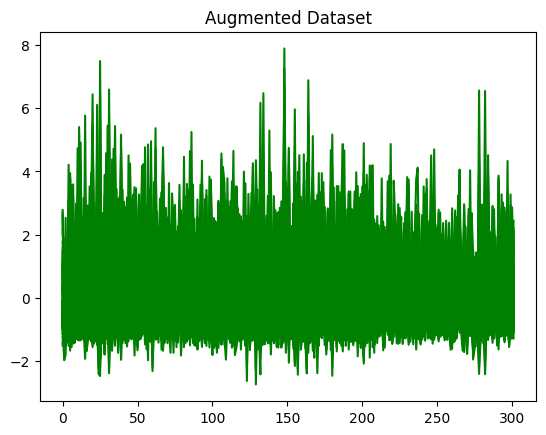

In [222]:
plt.plot(X_res, color='green')
plt.title('Augmented Dataset')
plt.show()

In [201]:
clf = SVC(random_state=42)
cv = StratifiedKFold(shuffle=True, random_state=42)
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel':['linear','rbf']}
search = HalvingGridSearchCV(clf, param_grid, cv = cv, random_state=42, scoring = 'f1', verbose=3, refit=True).fit(X_res, y_res)
print(search.best_params_)
print(search.best_score_) 

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 20
max_resources_: 302
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 20
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END C=0.1, gamma=1, kernel=linear;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END C=0.1, gamma=1, kernel=linear;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/5] END C=0.1, gamma=1, kernel=linear;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 4/5] END C=0.1, gamma=1, kernel=linear;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END C=0.1, gamma=1, kernel=linear;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.000, test=0.000) t

In [202]:
clf = search.best_estimator_
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(clf, X_res, y_res, cv=cv)
print(classification_report(y_res, y_pred, target_names=['healthy', 'pathological']))

              precision    recall  f1-score   support

     healthy       0.75      0.93      0.83       151
pathological       0.90      0.69      0.78       151

    accuracy                           0.81       302
   macro avg       0.83      0.81      0.81       302
weighted avg       0.83      0.81      0.81       302



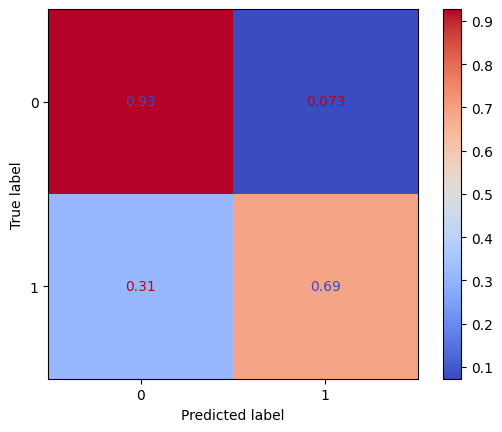

In [203]:
ConfusionMatrixDisplay.from_predictions(y_res, y_pred, cmap='coolwarm', normalize = 'true')
plt.show()